In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("..")   # add parent directory to Python path
import functions
from pathlib import Path
from tensorflow import keras
import csv
from sklearn.cluster import DBSCAN


In [3]:
loc = []
with open("../Re_ defibrillation codes/maskcircle.csv") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        i = -1
        for value in row[2:]:
            i += 1
            if i % 4 ==0:
                loc.append(int(value))
circle_area = sum(loc)/len(loc)

In [4]:
FTE = []
with open("../Re_ defibrillation codes/data_1/FTE.csv") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        for value in row[1:]:
            FTE.append(float(value)/circle_area)

Text(0, 0.5, 'FTE')

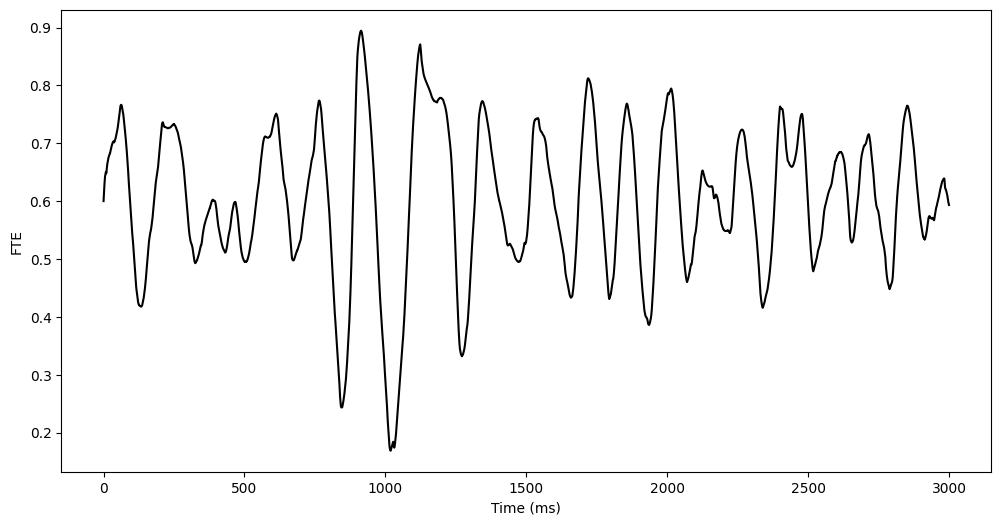

# Spiral Number (SN)

In [160]:
def findSN(file,plot = False):

    csv.field_size_limit(sys.maxsize)

    data = []
    with open(file, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            for i in row:
                data.append(int(i))
    data_ = np.array(data).reshape((1024, 1024, 4))

    # change all [1,1,1,1] pixels near circle radius=512 to [1,0,0,0]
    epsilon = 100 * 512
    for i in range(data_.shape[0]):
        for j in range(data_.shape[1]):
            r2 = (i - 512) ** 2 + (j - 512) ** 2
            if (512) ** 2 - epsilon <= r2 <= (512) ** 2 + epsilon:
                if (data_[i, j] == [1, 1, 1, 1]).all():
                    data_[i, j] = [1, 0, 0, 0]

    # mask and coordinates
    mask = np.all(data_ == 1, axis=-1)
    mask_boundary = np.all(data_ == [1, 0, 0, 0], axis=-1)
    ys, xs = np.where(mask)
    ybs, xbs = np.where(mask_boundary)

    # ==================================================
    # 2. Cluster nearby red points
    # ==================================================
    if len(xs) == 0:
        print(file + " has no tip points.")
        labels = np.array([])
        num_clusters = 0
    else:
        points = np.column_stack((xs, ys))
        eps = 30
        clustering = DBSCAN(eps=eps, min_samples=1).fit(points)
        labels = clustering.labels_
        num_clusters = len(set(labels)) - (1 if -1 in labels else 0) # -1 for noise

    if plot:
        # ==================================================
        # 3. Plot two subplots side by side
        # ==================================================
        fig, axes = plt.subplots(1, 2, figsize=(16, 8))

        # -----------------------
        # (a) Original map
        # -----------------------
        ax = axes[0]
        ax.imshow(data_[..., :3] * 512, interpolation='nearest')
        for (x, y) in zip(xs, ys):
            circ = plt.Circle((x, y), radius=10, color='red', fill=False, linewidth=0.8)
            ax.add_patch(circ)
        for (x, y) in zip(xbs, ybs):
            circ = plt.Circle((x, y), radius=10, color='blue', fill=False, linewidth=0.8)
            ax.add_patch(circ)
        center_circle = plt.Circle((512, 512), radius=512,
                                color='cyan', fill=False, linewidth=1.2, linestyle='--')
        ax.add_patch(center_circle)
        ax.invert_yaxis()
        ax.set_title("Original Map")

        # -----------------------
        # (b) Grouped (DBSCAN)
        # -----------------------
        ax = axes[1]
        ax.imshow(data_[..., :3] * 512, interpolation='nearest')
        cmap = plt.cm.get_cmap('hsv', num_clusters + 1)
        for label in np.unique(labels):
            if label == -1:
                continue
            cluster_points = points[labels == label]
            ax.scatter(cluster_points[:, 0], cluster_points[:, 1],
                    s=30, color=cmap(label), label=f'Group {label}', alpha=0.8)
        ax.legend(fontsize=8, loc='upper right')
        ax.invert_yaxis()
        ax.set_title("Grouped Clusters (DBSCAN)")

        plt.tight_layout()
        plt.show()
    return num_clusters



# Shannon Entropy (SE) Tsallis Entropy (TE) G4

In [172]:
def load_voltage(file,plot = False): # return array
    # load voltage as 1024*1024*4 array
    array = []
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            for value in row[2:]:
                array.append((float(value)))
    array = np.array(array).reshape((1024,1024,4))
    # only retain values with circle with r = 512
    mask = np.zeros((1024,1024), dtype=bool)
    for i in range(1024):
        for j in range(1024):
            r2 = (i - 512) ** 2 + (j - 512) ** 2
            if r2 <= (512) ** 2:
                mask[i, j] = True
    array[~mask] = np.nan
    if plot:
        plt.imshow(array[:,:,0])
    return array

In [ ]:
def cal_shannon_entropy(array, plot=False): # return shannon and tsallis entropy
        values = array[:, :, 0].flatten()
        values = values[~np.isnan(values)]

        # ---- reuse histogram from your Shannon calculation ----
        counts, bins = np.histogram(values, bins=100)
        percentages = counts / counts.sum() * 100  # for plotting only

        # ---- probabilities ----
        p = counts / np.sum(counts)
        p = p[p > 0]  # avoid log(0)

        # ---- Shannon entropy (for reference) ----
        H = -np.sum(p * np.log2(p))
        H_scaled = H / np.log2(len(p))

        # ---- Tsallis entropy ----
        q = 2.0  # choose any q ≠ 1 (e.g. 0.8, 1.2, 1.5, etc.)
        S_q = (1 - np.sum(p**q)) / (q - 1)

        # normalized Tsallis entropy (same 0–1 scaling idea)
        S_q_max = (1 - len(p)**(1 - q)) / (q - 1)
        S_q_scaled = S_q / S_q_max if S_q_max != 0 else 0

        if plot:
                # ---- Plot histogram with both values ----
                plt.figure(figsize=(8, 6))
                plt.bar(bins[:-1], percentages, width=np.diff(bins), align='edge',
                        color='blue', edgecolor='black')
                plt.ylabel('Percentage (%)')
                plt.xlabel('Value')
                plt.title(f'Shannon = {H_scaled:.3f}   |   Tsallis (q={q}) = {S_q_scaled:.3f}')
                plt.tight_layout()
                plt.show()
        return H_scaled, S_q_scaled


# defrib stat

In [183]:
def load_defrib_results(file):
    output = {}
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            #row = '....fcolor_{time}ms.cvsv'
            time = int(row[0].split('_')[-1].replace('ms.csv',''))
            defrib_times = int(row[1])
            output[time] = defrib_times
    return output

# calculate them

In [ ]:
dt = 0.015*2
x_time = [i*dt for i in range(len(FTE))]
x_time2 = range(5,int(x_time[-1]),5)
x_time2 = range(5,2165,5)

SN_lib = {}
SE_lib = {}
TSA_lib = {}
for time in x_time2:
    if time % 100 == 0:
        print(f"Processing time: {time} ms")    
    file_name = f"../Re_ defibrillation codes/data_1/tip_{time}ms.csv"
    SN_lib[time] = findSN(file_name,plot=False)
    cur_array = load_voltage(file_name.replace("tip", "fcolor"))
    SE,TSA = cal_shannon_entropy(cur_array, plot=False)
    SE_lib[time] = SE
    TSA_lib[time] = TSA


Processing time: 100 ms
../Re_ defibrillation codes/data_1/tip_145ms.csv has no tip points.
Processing time: 200 ms
../Re_ defibrillation codes/data_1/tip_205ms.csv has no tip points.
../Re_ defibrillation codes/data_1/tip_265ms.csv has no tip points.
Processing time: 300 ms
../Re_ defibrillation codes/data_1/tip_325ms.csv has no tip points.
../Re_ defibrillation codes/data_1/tip_385ms.csv has no tip points.
Processing time: 400 ms
../Re_ defibrillation codes/data_1/tip_445ms.csv has no tip points.
Processing time: 500 ms
../Re_ defibrillation codes/data_1/tip_505ms.csv has no tip points.
../Re_ defibrillation codes/data_1/tip_565ms.csv has no tip points.
Processing time: 600 ms
../Re_ defibrillation codes/data_1/tip_625ms.csv has no tip points.
../Re_ defibrillation codes/data_1/tip_685ms.csv has no tip points.
Processing time: 700 ms
../Re_ defibrillation codes/data_1/tip_745ms.csv has no tip points.
Processing time: 800 ms
../Re_ defibrillation codes/data_1/tip_805ms.csv has no tip 

In [188]:
defrib_lib = load_defrib_results('../Re_ defibrillation codes/data_1/defribs_results.csv')

In [190]:
max(defrib_lib.keys())

2160

# plot

Text(0.5, 0, 'Time (ms)')

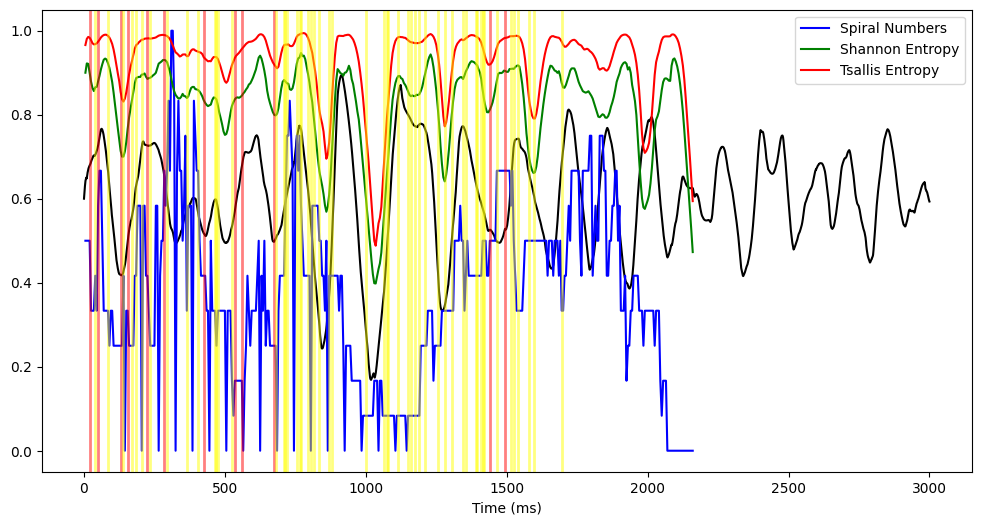

In [197]:
plt.figure(figsize=(12, 6))
#plot the defrib_dict to the plot with key on x and value as differnt vertical color lines, with color value equal to the value in the dict, 1-5 green, 6-10 yellow, above 10 red
#for key, value in defrib_dict.items():
    #plt.axvline(x=key*33.333, color='g' if value <= 4 else 'yellow' if value <= 7 else 'r', linewidth=4) # also add width for line
    

dt = 0.015*2
x_time = [i*dt for i in range(len(FTE))]
SN = [SN_lib[t] for t in x_time2]
SN = [i/max(SN) for i in SN]
SE = [SE_lib[t] for t in x_time2]
TSA = [TSA_lib[t] for t in x_time2]
plt.plot(x_time, FTE, color='k')
plt.plot(x_time2, SN, label='Spiral Numbers', color='b')
plt.plot(x_time2, SE, label='Shannon Entropy', color='g')
plt.plot(x_time2, TSA, label='Tsallis Entropy', color='r')
# plot defrib times as vertical lines
#  dont plot v<= 4
for key, value in defrib_lib.items():
    if value > 4:
        plt.axvline(x=key, color='white' if value <= 4 else 'yellow' if value <= 7 else 'r', linewidth=2, alpha=0.5) # also add width for line
plt.legend()
plt.xlabel('Time (ms)')
#plt.ylabel('FTE')

C:\Users\xan37\AppData\Local\Temp\ipykernel_27804\2914438220.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Reds')


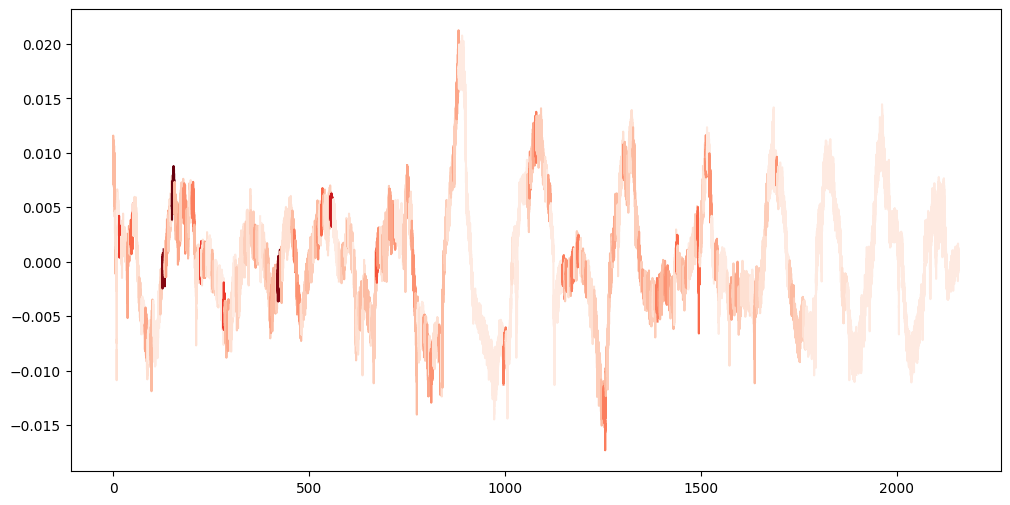

In [318]:
import matplotlib.cm as cm

plt.figure(figsize=(12, 6))
FTE_slope = np.diff(FTE)/dt

# now make the color of FTE_slope determined by its neareset defrib result
color = []
for i in range(len(FTE_slope)):
    time_now = x_time[i]
    if time_now < 2160:
        if time_now % 5 <= 2.5:
            j = defrib_lib[time_now-time_now%5]
        else:
            j = defrib_lib[time_now-time_now%5+5]
    else:
        j = 0
    color.append(j)
max_color = max(color)
min_color = min(color)
color = [(i - min_color) / (max_color - min_color) for i in color]
cmap = cm.get_cmap('Reds')   
# plot FTE_slope with color determined by j
for i in range(10,len(FTE_slope),100):
    time_now = x_time[i]
    if time_now > 2160:
        break
    plt.plot(x_time[i-100:i], FTE_slope[i-100:i], color=cmap(color[i]))


In [334]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import numpy as np
FTE_small_reso = [FTE[i] for i in x_time2]
FTE_slope_small_reso = [FTE_slope[i] for i in x_time2]
X = np.column_stack((SN, SE, TSA, FTE_small_reso, FTE_slope_small_reso))
y = np.array([1 if y > 7 else 0 if y > 4 else -1 for (x,y) in defrib_lib.items() if x > 0])

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# train
model = DecisionTreeClassifier(max_depth=2, random_state=42)
model.fit(X_train, y_train)

# predict (will be only 0, 0.5, or 1)
y_pred = model.predict(X_test)

# evaluate
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy = {acc:.3f}")
print(classification_report(y_test, y_pred))


Test Accuracy = 0.886
              precision    recall  f1-score   support

          -1       0.89      1.00      0.94        39
           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         1

    accuracy                           0.89        44
   macro avg       0.30      0.33      0.31        44
weighted avg       0.79      0.89      0.83        44



c:\Users\xan37\AppData\Local\anaconda3\envs\lstm\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\xan37\AppData\Local\anaconda3\envs\lstm\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\xan37\AppData\Local\anaconda3\envs\lstm\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"

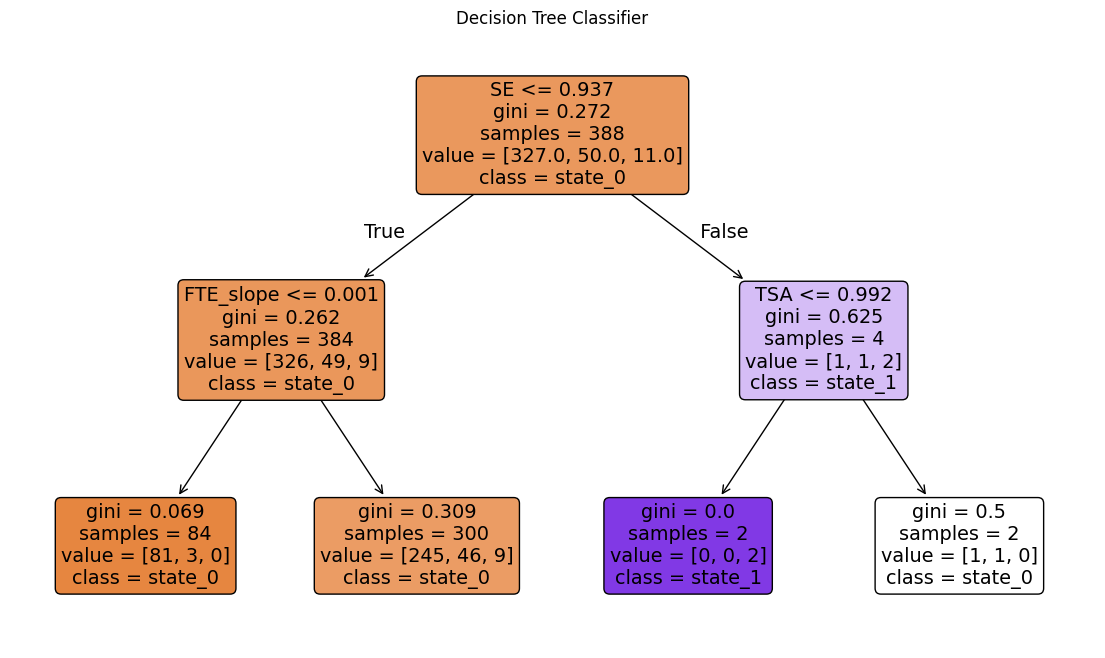

In [335]:
from sklearn import tree
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
tree.plot_tree(
    model,
    feature_names=["SN", "SE", "TSA", "FTE","FTE_slope"],
    class_names=["state_0", "state_05", "state_1"],
    filled=True,
    rounded=True
)
plt.title("Decision Tree Classifier")
plt.show()
